In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transform
import matplotlib.pyplot as plt
import os
import random
import numpy as np
import timm
from torch.optim.lr_scheduler import LambdaLR

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
!gdown 18y-G6r5rnfRpKHc9VTN7kxJMAYPJWze8

Downloading...
From (original): https://drive.google.com/uc?id=18y-G6r5rnfRpKHc9VTN7kxJMAYPJWze8
From (redirected): https://drive.google.com/uc?id=18y-G6r5rnfRpKHc9VTN7kxJMAYPJWze8&confirm=t&uuid=4a2818f0-8c13-477f-941f-fc42a0d7cea7
To: /content/img_cls_weather_dataset.zip
100% 613M/613M [00:01<00:00, 307MB/s]


In [3]:
!unzip img_cls_weather_dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: weather-dataset/dataset/frost/3922.jpg  
  inflating: weather-dataset/dataset/frost/3923.jpg  
  inflating: weather-dataset/dataset/frost/3924.jpg  
  inflating: weather-dataset/dataset/frost/3925.jpg  
  inflating: weather-dataset/dataset/frost/3926.jpg  
  inflating: weather-dataset/dataset/frost/3927.jpg  
  inflating: weather-dataset/dataset/frost/3928.jpg  
  inflating: weather-dataset/dataset/frost/3929.jpg  
  inflating: weather-dataset/dataset/frost/3930.jpg  
  inflating: weather-dataset/dataset/frost/3931.jpg  
  inflating: weather-dataset/dataset/frost/3932.jpg  
  inflating: weather-dataset/dataset/frost/3933.jpg  
  inflating: weather-dataset/dataset/frost/3934.jpg  
  inflating: weather-dataset/dataset/frost/3935.jpg  
  inflating: weather-dataset/dataset/frost/3936.jpg  
  inflating: weather-dataset/dataset/frost/3937.jpg  
  inflating: weather-dataset/dataset/frost/3938.jpg  
  inflating: weather-dataset/da

In [4]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
seed=42
set_seed(seed)

In [5]:
root_dir= '/content/weather-dataset/dataset'
classes = {
    label_idx: class_name \
        for label_idx, class_name in enumerate(
            sorted(os.listdir(root_dir))
        )
}

In [6]:
classes

{0: 'dew',
 1: 'fogsmog',
 2: 'frost',
 3: 'glaze',
 4: 'hail',
 5: 'lightning',
 6: 'rain',
 7: 'rainbow',
 8: 'rime',
 9: 'sandstorm',
 10: 'snow'}

In [7]:
img_paths = []
labels = []
for label_idx, class_name in classes.items():
    class_dir = os.path.join(root_dir, class_name)
    for img_filename in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_filename)
        img_paths.append(img_path)
        labels.append(label_idx)


In [8]:
img_paths

['/content/weather-dataset/dataset/dew/2812.jpg',
 '/content/weather-dataset/dataset/dew/2874.jpg',
 '/content/weather-dataset/dataset/dew/2213.jpg',
 '/content/weather-dataset/dataset/dew/2709.jpg',
 '/content/weather-dataset/dataset/dew/2427.jpg',
 '/content/weather-dataset/dataset/dew/2373.jpg',
 '/content/weather-dataset/dataset/dew/2614.jpg',
 '/content/weather-dataset/dataset/dew/2295.jpg',
 '/content/weather-dataset/dataset/dew/2754.jpg',
 '/content/weather-dataset/dataset/dew/2356.jpg',
 '/content/weather-dataset/dataset/dew/2888.jpg',
 '/content/weather-dataset/dataset/dew/2476.jpg',
 '/content/weather-dataset/dataset/dew/2822.jpg',
 '/content/weather-dataset/dataset/dew/2439.jpg',
 '/content/weather-dataset/dataset/dew/2722.jpg',
 '/content/weather-dataset/dataset/dew/2771.jpg',
 '/content/weather-dataset/dataset/dew/2624.jpg',
 '/content/weather-dataset/dataset/dew/2711.jpg',
 '/content/weather-dataset/dataset/dew/2800.jpg',
 '/content/weather-dataset/dataset/dew/2585.jpg',


In [9]:
from sklearn.model_selection import train_test_split

In [10]:
val_size= 0.2
test_size= 0.125
is_shuffle= True

X_train, X_val, y_train, y_val = train_test_split(
    img_paths, labels,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle
)

In [11]:
class WeatherDataset(Dataset):
  def __init__(
      self,
      X, y,
      transform= None
    ):
    self.transform= transform
    self.img_paths= X
    self.labels= y

  def __len__(self):
    return len(self.img_paths)

  def __getitem__(self, index):
    img_path= self.img_paths[index]
    img= Image.open(img_path)
    img= img.convert('RGB')
    if self.transform:
      img= self.transform(img)

    return img, self.labels[index]


In [12]:
def transform(img, img_size=(224, 224)):
  img= img.resize(img_size)
  img= np.array(img)[..., :3]
  img= torch.tensor(img).permute(2, 0, 1).float()
  normalized_img= img/ 255.0

  return normalized_img

In [13]:
train_dataset= WeatherDataset(
    X_train, y_train,
    transform= transform
)

val_dataset= WeatherDataset(
    X_val, y_val,
    transform= transform
)
test_dataset= WeatherDataset(
    X_test, y_test,
    transform= transform
)


In [14]:

train_batch_size= 256
test_batch_size= 128

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

Feature batch shape: torch.Size([256, 3, 224, 224])
Labels batch shape: torch.Size([256])


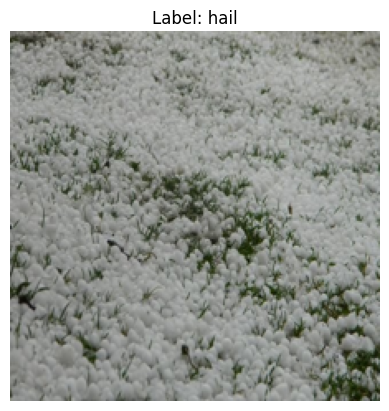

In [15]:
train_features, train_labels = next(iter(train_loader))
print(f'Feature batch shape: {train_features.size()}')
print(f'Labels batch shape: {train_labels.size()}')
img = train_features[0].permute(1, 2, 0)
label = train_labels[0].item()
plt.imshow(img)
plt.axis('off')
plt.title(f'Label: {classes[label]}')
plt.show()

In [25]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels, out_channels,
            kernel_size=3, stride=stride, padding=1
        )
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(
            out_channels, out_channels,
            kernel_size=3, stride=1, padding=1
        )
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels,
                    kernel_size=1, stride=stride
                ),
                nn.BatchNorm2d(out_channels)
            )
        self.relu = nn.ReLU()

    def forward(self, x):
        shortcut = x.clone()
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x += self.downsample(shortcut)
        x = self.relu(x)

        return x

In [26]:
class ResNet(nn.Module):
    def __init__(self, residual_block, n_blocks_lst, n_classes):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = self.create_layer(residual_block, 64, 64, n_blocks_lst[0], 1)
        self.conv3 = self.create_layer(residual_block, 64, 128, n_blocks_lst[1], 2)
        self.conv4 = self.create_layer(residual_block, 128, 256, n_blocks_lst[2], 2)
        self.conv5 = self.create_layer(residual_block, 256, 512, n_blocks_lst[3], 2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512, n_classes)

    def create_layer(self, residual_block, in_channels, out_channels, n_blocks, stride):
        blocks = []
        first_block = residual_block(in_channels, out_channels, stride)
        blocks.append(first_block)

        for idx in range(1, n_blocks):
            block = residual_block(out_channels, out_channels, stride=1)
            blocks.append(block)

        block_sequential = nn.Sequential(*blocks)

        return block_sequential


    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc1(x)

        return x

In [28]:
n_classes = len(list(classes.keys()))
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = ResNet(
    residual_block=ResidualBlock,
    n_blocks_lst=[3, 4, 6, 3],
    n_classes=n_classes
).to(device)

In [29]:
model.eval()

dummy_tensor = torch.randn(1, 3, 224, 224).to(device)

with torch.no_grad():
    output = model(dummy_tensor)

print('Output shape:', output.shape)

Output shape: torch.Size([1, 11])


In [30]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [32]:
def fit_teaacher(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
):
    train_losses = []
    val_losses = []
    val_accs = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            model, val_loader,
            criterion, device
        )
        val_accs.append(val_acc)
        val_losses.append(val_loss)
        scheduler.step()

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}\tVal acc: {val_acc:.4f}')

    return train_losses, val_losses, val_accs

In [33]:
lr = 1e-2
epochs = 30

def lr_lambda(epoch, warmup_epochs=5, total_epochs=30, init_scale=0.1, min_scale=0.3):
    scale_range = 1.0 - min_scale

    if epoch < warmup_epochs:
        warmup_factor = epoch / warmup_epochs
        return init_scale + (1.0 - init_scale) * warmup_factor

    decay_factor = (total_epochs - epoch) / (total_epochs - warmup_epochs)
    return min_scale + scale_range * max(0.0, decay_factor)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=lr
)

scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

In [34]:
for epoch in range(epochs):
    print(f'Epoch {epoch}, LR: {lr * lr_lambda(epoch):.6f}')

Epoch 0, LR: 0.001000
Epoch 1, LR: 0.002800
Epoch 2, LR: 0.004600
Epoch 3, LR: 0.006400
Epoch 4, LR: 0.008200
Epoch 5, LR: 0.010000
Epoch 6, LR: 0.009720
Epoch 7, LR: 0.009440
Epoch 8, LR: 0.009160
Epoch 9, LR: 0.008880
Epoch 10, LR: 0.008600
Epoch 11, LR: 0.008320
Epoch 12, LR: 0.008040
Epoch 13, LR: 0.007760
Epoch 14, LR: 0.007480
Epoch 15, LR: 0.007200
Epoch 16, LR: 0.006920
Epoch 17, LR: 0.006640
Epoch 18, LR: 0.006360
Epoch 19, LR: 0.006080
Epoch 20, LR: 0.005800
Epoch 21, LR: 0.005520
Epoch 22, LR: 0.005240
Epoch 23, LR: 0.004960
Epoch 24, LR: 0.004680
Epoch 25, LR: 0.004400
Epoch 26, LR: 0.004120
Epoch 27, LR: 0.003840
Epoch 28, LR: 0.003560
Epoch 29, LR: 0.003280


In [35]:
train_losses, val_losses, val_accs = fit_teaacher(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
)

EPOCH 1:	Train loss: 2.3016	Val loss: 2.3894	Val acc: 0.1231
EPOCH 2:	Train loss: 1.8692	Val loss: 2.5465	Val acc: 0.1479
EPOCH 3:	Train loss: 1.4848	Val loss: 1.6911	Val acc: 0.4530
EPOCH 4:	Train loss: 1.2759	Val loss: 1.4080	Val acc: 0.5106
EPOCH 5:	Train loss: 1.1971	Val loss: 1.3095	Val acc: 0.5361
EPOCH 6:	Train loss: 1.0867	Val loss: 1.3075	Val acc: 0.5557
EPOCH 7:	Train loss: 1.0238	Val loss: 1.4791	Val acc: 0.5018
EPOCH 8:	Train loss: 0.9071	Val loss: 1.7765	Val acc: 0.4975
EPOCH 9:	Train loss: 0.8209	Val loss: 2.0476	Val acc: 0.4210
EPOCH 10:	Train loss: 0.8045	Val loss: 1.2271	Val acc: 0.5849
EPOCH 11:	Train loss: 0.6863	Val loss: 1.1586	Val acc: 0.6103
EPOCH 12:	Train loss: 0.6538	Val loss: 1.3694	Val acc: 0.5870
EPOCH 13:	Train loss: 0.5509	Val loss: 1.5702	Val acc: 0.5899
EPOCH 14:	Train loss: 0.5365	Val loss: 1.4837	Val acc: 0.5798
EPOCH 15:	Train loss: 0.4475	Val loss: 1.7607	Val acc: 0.5426
EPOCH 16:	Train loss: 0.3930	Val loss: 1.4019	Val acc: 0.5594
EPOCH 17:	Train l

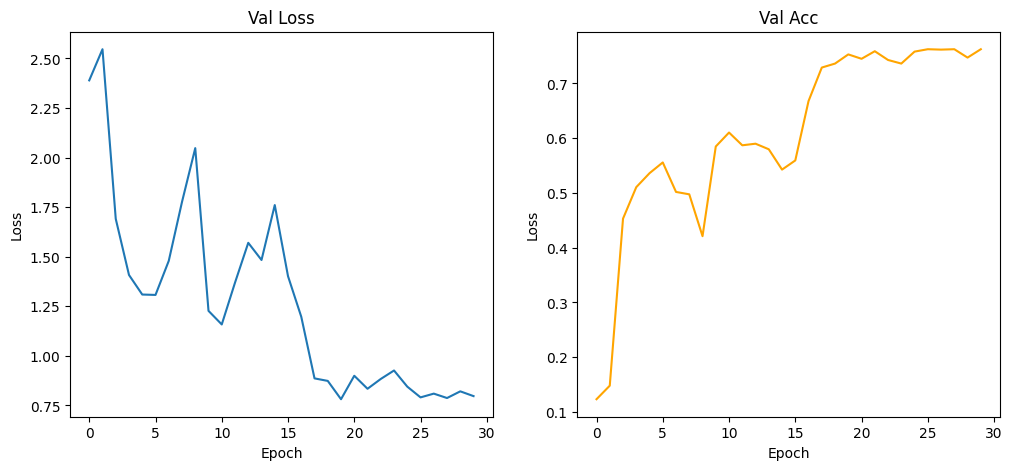

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(val_losses)
ax[0].set_title('Val Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_accs, color='orange')
ax[1].set_title('Val Acc')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

In [37]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluation on val/test dataset
Val accuracy:  0.7625637290604516
Test accuracy:  0.7714701601164483


In [38]:
save_path = 'teacher_wt.pt'
torch.save(model.state_dict(), save_path)

## ResponeBase From Teacher2Student

In [39]:
teacher_model = ResNet(
    residual_block=ResidualBlock,
    n_blocks_lst=[3, 4, 6, 3],
    n_classes=n_classes
).to(device)

teacher_model.load_state_dict(
    torch.load(
        'teacher_wt.pt',
        map_location=device
    )
)

student_model = ResNet(
    residual_block=ResidualBlock,
    n_blocks_lst=[2, 2, 2, 2],
    n_classes=n_classes
).to(device)

In [40]:
teacher_model.eval()
student_model.eval()

dummy_tensor = torch.randn(1, 3, 224, 224).to(device)

with torch.no_grad():
    teacher_output = teacher_model(dummy_tensor)
    student_output = student_model(dummy_tensor)


print('Teacher output shape:', teacher_output.shape)
print('Student output shape:', student_output.shape)

Teacher output shape: torch.Size([1, 11])
Student output shape: torch.Size([1, 11])


In [41]:
def fit(
    teacher,
    student,
    T,
    soft_target_loss_weight,
    ce_loss_weight,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
):
    train_losses = []
    val_losses = []
    val_accs = []
    teacher.eval()

    for epoch in range(epochs):
        batch_train_losses = []

        student.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.no_grad():
                teacher_logits = teacher(inputs)
            student_logits = student(inputs)

            soft_targets = nn.functional.softmax(teacher_logits / T, dim=-1)
            soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1)

            soft_targets_loss = torch.sum(soft_targets * (soft_targets.log() - soft_prob)) / soft_prob.size()[0] * (T**2)
            label_loss = criterion(student_logits, labels)

            loss = soft_target_loss_weight * soft_targets_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            student, val_loader,
            criterion, device
        )
        val_accs.append(val_acc)
        val_losses.append(val_loss)
        scheduler.step()

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}\tVal acc: {val_acc:.4f}')

    return train_losses, val_losses, val_accs

In [42]:
lr = 1e-2
epochs = 30

def lr_lambda(epoch, warmup_epochs=5, total_epochs=30, init_scale=0.1, min_scale=0.3):
    scale_range = 1.0 - min_scale

    if epoch < warmup_epochs:
        warmup_factor = epoch / warmup_epochs
        return init_scale + (1.0 - init_scale) * warmup_factor

    decay_factor = (total_epochs - epoch) / (total_epochs - warmup_epochs)
    return min_scale + scale_range * max(0.0, decay_factor)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    student_model.parameters(),
    lr=lr
)

scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

In [43]:
for epoch in range(epochs):
    print(f'Epoch {epoch}, LR: {lr * lr_lambda(epoch):.6f}')

Epoch 0, LR: 0.001000
Epoch 1, LR: 0.002800
Epoch 2, LR: 0.004600
Epoch 3, LR: 0.006400
Epoch 4, LR: 0.008200
Epoch 5, LR: 0.010000
Epoch 6, LR: 0.009720
Epoch 7, LR: 0.009440
Epoch 8, LR: 0.009160
Epoch 9, LR: 0.008880
Epoch 10, LR: 0.008600
Epoch 11, LR: 0.008320
Epoch 12, LR: 0.008040
Epoch 13, LR: 0.007760
Epoch 14, LR: 0.007480
Epoch 15, LR: 0.007200
Epoch 16, LR: 0.006920
Epoch 17, LR: 0.006640
Epoch 18, LR: 0.006360
Epoch 19, LR: 0.006080
Epoch 20, LR: 0.005800
Epoch 21, LR: 0.005520
Epoch 22, LR: 0.005240
Epoch 23, LR: 0.004960
Epoch 24, LR: 0.004680
Epoch 25, LR: 0.004400
Epoch 26, LR: 0.004120
Epoch 27, LR: 0.003840
Epoch 28, LR: 0.003560
Epoch 29, LR: 0.003280


In [44]:
train_losses, val_losses, val_accs = fit(
    teacher_model,
    student_model,
    2,
    0.25,
    0.75,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
)

EPOCH 1:	Train loss: 3.2099	Val loss: 2.4218	Val acc: 0.1231
EPOCH 2:	Train loss: 2.5073	Val loss: 2.0825	Val acc: 0.2746
EPOCH 3:	Train loss: 1.9971	Val loss: 1.4710	Val acc: 0.4924
EPOCH 4:	Train loss: 1.7169	Val loss: 1.5383	Val acc: 0.4494
EPOCH 5:	Train loss: 1.5569	Val loss: 1.4679	Val acc: 0.5047
EPOCH 6:	Train loss: 1.4690	Val loss: 1.5953	Val acc: 0.5084
EPOCH 7:	Train loss: 1.3175	Val loss: 1.5785	Val acc: 0.5098
EPOCH 8:	Train loss: 1.1887	Val loss: 2.0388	Val acc: 0.4392
EPOCH 9:	Train loss: 1.1745	Val loss: 1.2922	Val acc: 0.5819
EPOCH 10:	Train loss: 1.0591	Val loss: 1.6793	Val acc: 0.5273
EPOCH 11:	Train loss: 0.9610	Val loss: 1.1182	Val acc: 0.6395
EPOCH 12:	Train loss: 0.9010	Val loss: 2.4028	Val acc: 0.4261
EPOCH 13:	Train loss: 0.8801	Val loss: 2.1232	Val acc: 0.4195
EPOCH 14:	Train loss: 0.8176	Val loss: 1.2557	Val acc: 0.6089
EPOCH 15:	Train loss: 0.7449	Val loss: 1.5897	Val acc: 0.5921
EPOCH 16:	Train loss: 0.7120	Val loss: 1.0647	Val acc: 0.6781
EPOCH 17:	Train l

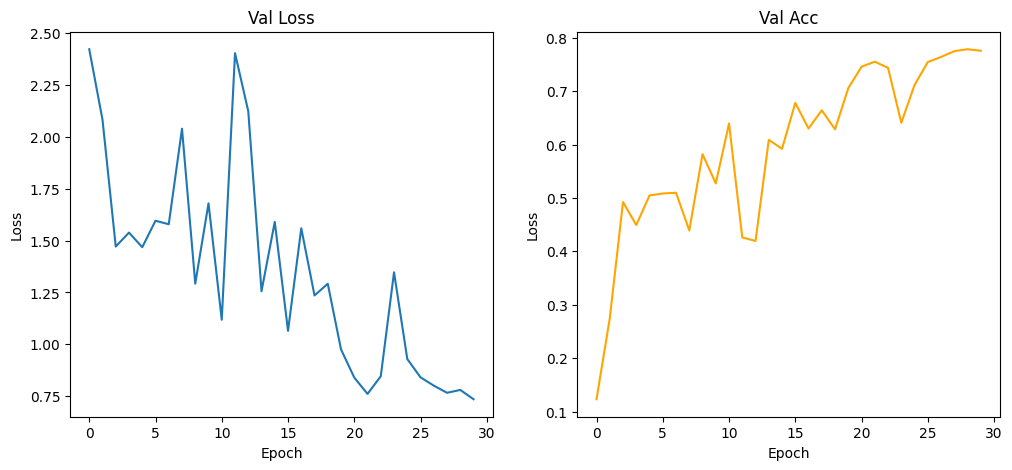

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(val_losses)
ax[0].set_title('Val Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_accs, color='orange')
ax[1].set_title('Val Acc')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

In [46]:
val_loss, val_acc = evaluate(
    student_model,
    val_loader,
    criterion,
    device
)
test_loss, test_acc = evaluate(
    student_model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluation on val/test dataset
Val accuracy:  0.775673707210488
Test accuracy:  0.7816593886462883


In [47]:
save_path = '/content/kdsamedata_wt.pt'
torch.save(student_model.state_dict(), save_path)